In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# Statistical Data Analysis

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns
sns.set(style ='white',font_scale=1.25)
%matplotlib inline

# Import all functions
from functions import *

# Set waring to 'ignore' to prevent them from prining on screen
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('data/wrangled_data.pkl','rb') as file:
    housing_orig, FEATURES,transformers = pickle.load(file)
print('Dimensions of the dataset',housing_orig[FEATURES['num']+FEATURES['cat']+FEATURES['aug_num']].shape)

Dimensions of the dataset (1454, 85)


In [4]:
housing = housing_orig.copy()
housing.head()
y = housing.SalePrice

## Numerical Features

In [5]:
housing_num = housing[FEATURES['num']+FEATURES['aug_num']]

### Correlation amongst Numerical Features

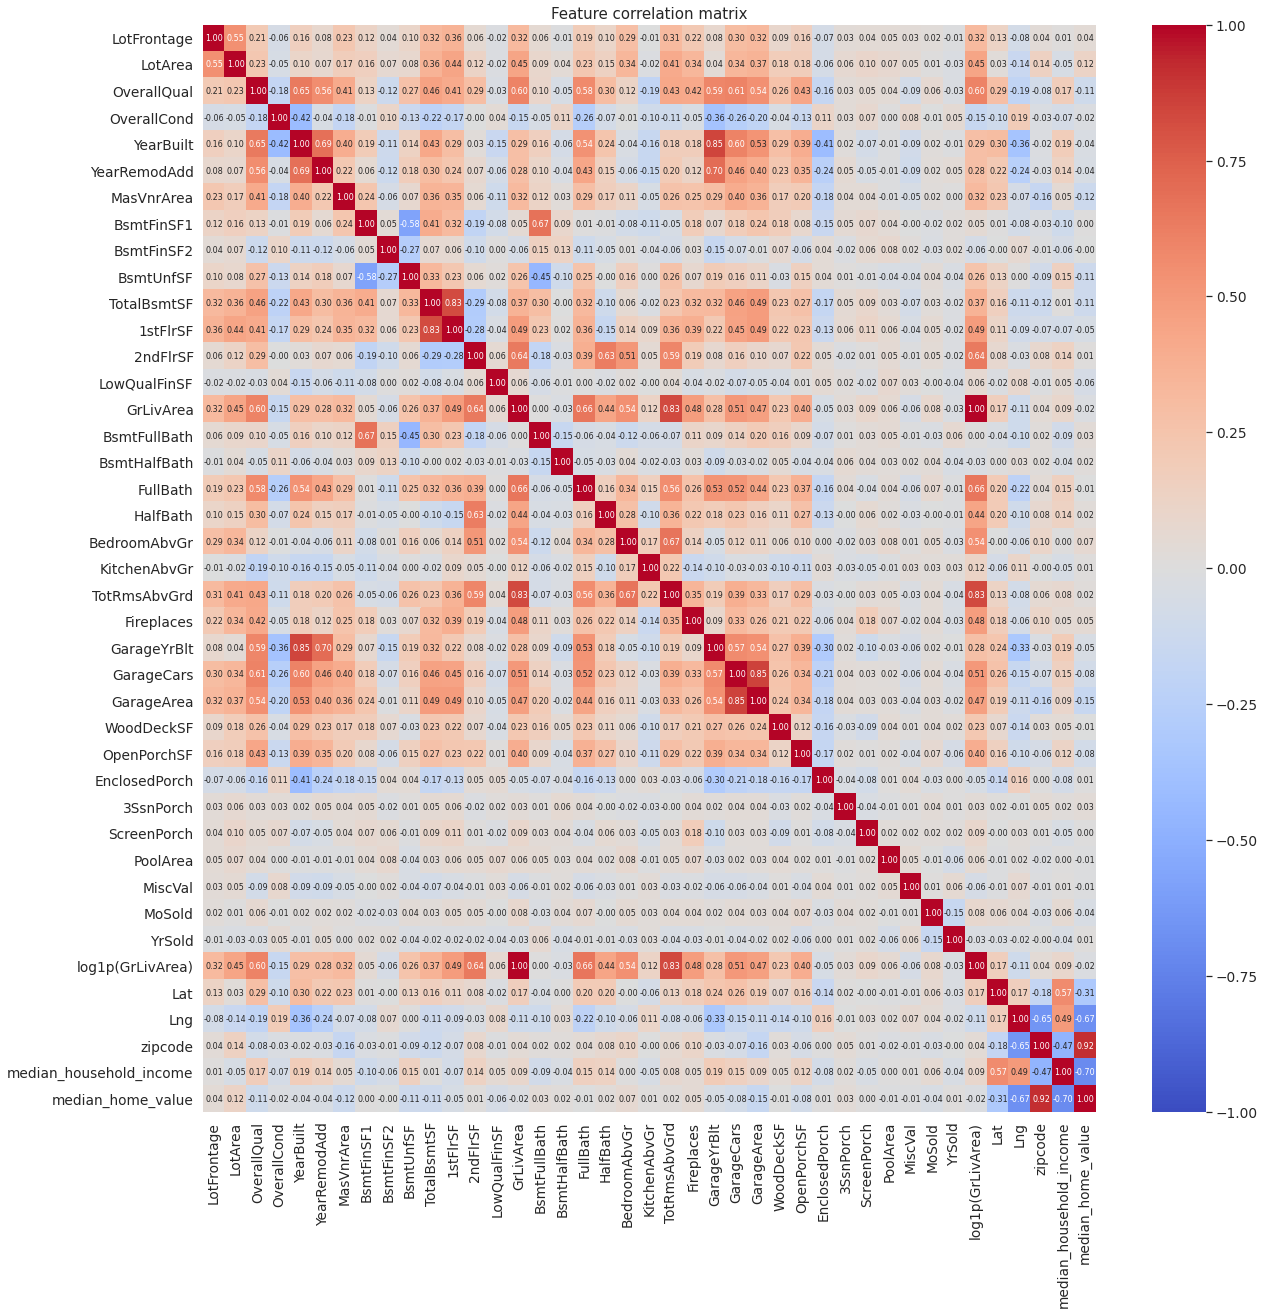

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(housing_num.corr(method='spearman'),
            vmax=1,vmin=-1,annot=True,
            cmap='coolwarm',
            fmt='.2f',annot_kws={'size':8})
_=plt.title("Feature correlation matrix")

Several numerical features are highly correlated with one another. Highest positive correlation is between house and garage year built (__YearBuilt__ and __GarageYrBlt__). This is not unexpected, as most house garages are built along with the house itself. A new feature called __GarageYrBltMinusYearBuilt__ is created, which models the difference between the year in which the garage and the house was built.

Second highest positive correlation is between total number of rooms (__TotRmsAbvGrd__) and log of total square feet area above ground (__log1p(GrLivArea)__). Its highly likely that __TotRmsAbvGrd__ is highly correlated with __GrLivArea__ itself. This is expected as houses with greater area tend to have more number of rooms. A new feature called __AreaPerRoom__ is added, which models the average area per room by dividing the __TotRmsAbvGrd__ by __GrLivArea__. 

Let’s check the correlation matrix again. 


In [7]:
from sklearn.preprocessing import FunctionTransformer

def addFeatures(X, new_features=['AreaPerRoom','GarageYrBltMinusYearBuilt']):
    for feat in new_features:
        if feat == 'AreaPerRoom':
            #GrLivArea = np.expm1(X['log1p(GrLivArea)'])
            X['AreaPerRoom'] = X['GrLivArea'].divide(X.TotRmsAbvGrd)
            X['log1p(AreaPerRoom)'] = np.log1p(X.AreaPerRoom)
        elif feat == 'GarageYrBltMinusYearBuilt':
            X['GarageYrBltMinusYearBuilt']=X['GarageYrBlt'].subtract(X.YearBuilt)
    return X

feature_adder = FunctionTransformer(addFeatures,validate=False,kw_args=dict(new_features =['AreaPerRoom','GarageYrBltMinusYearBuilt']))
transformers.append(('feature_adder',feature_adder))
housing = feature_adder.fit_transform(housing)

In [8]:
#GrLivArea = np.expm1(housing_num['log1p(GrLivArea)'])
housing_num['AreaPerRoom'] = housing_num['GrLivArea'].divide(housing_num.TotRmsAbvGrd)
housing_num['log1p(AreaPerRoom)'] = np.log1p(housing_num['AreaPerRoom'])
housing_num['GarageYrBltMinusYearBuilt'] = housing_num['GarageYrBlt'].subtract(housing_num.YearBuilt)

# Add the engineered features
FEATURES['eng_num'].extend(['AreaPerRoom','log1p(AreaPerRoom)','GarageYrBltMinusYearBuilt'])

In [9]:
housing_num.equals(housing[FEATURES['num']+FEATURES['aug_num']+FEATURES['eng_num']])

True

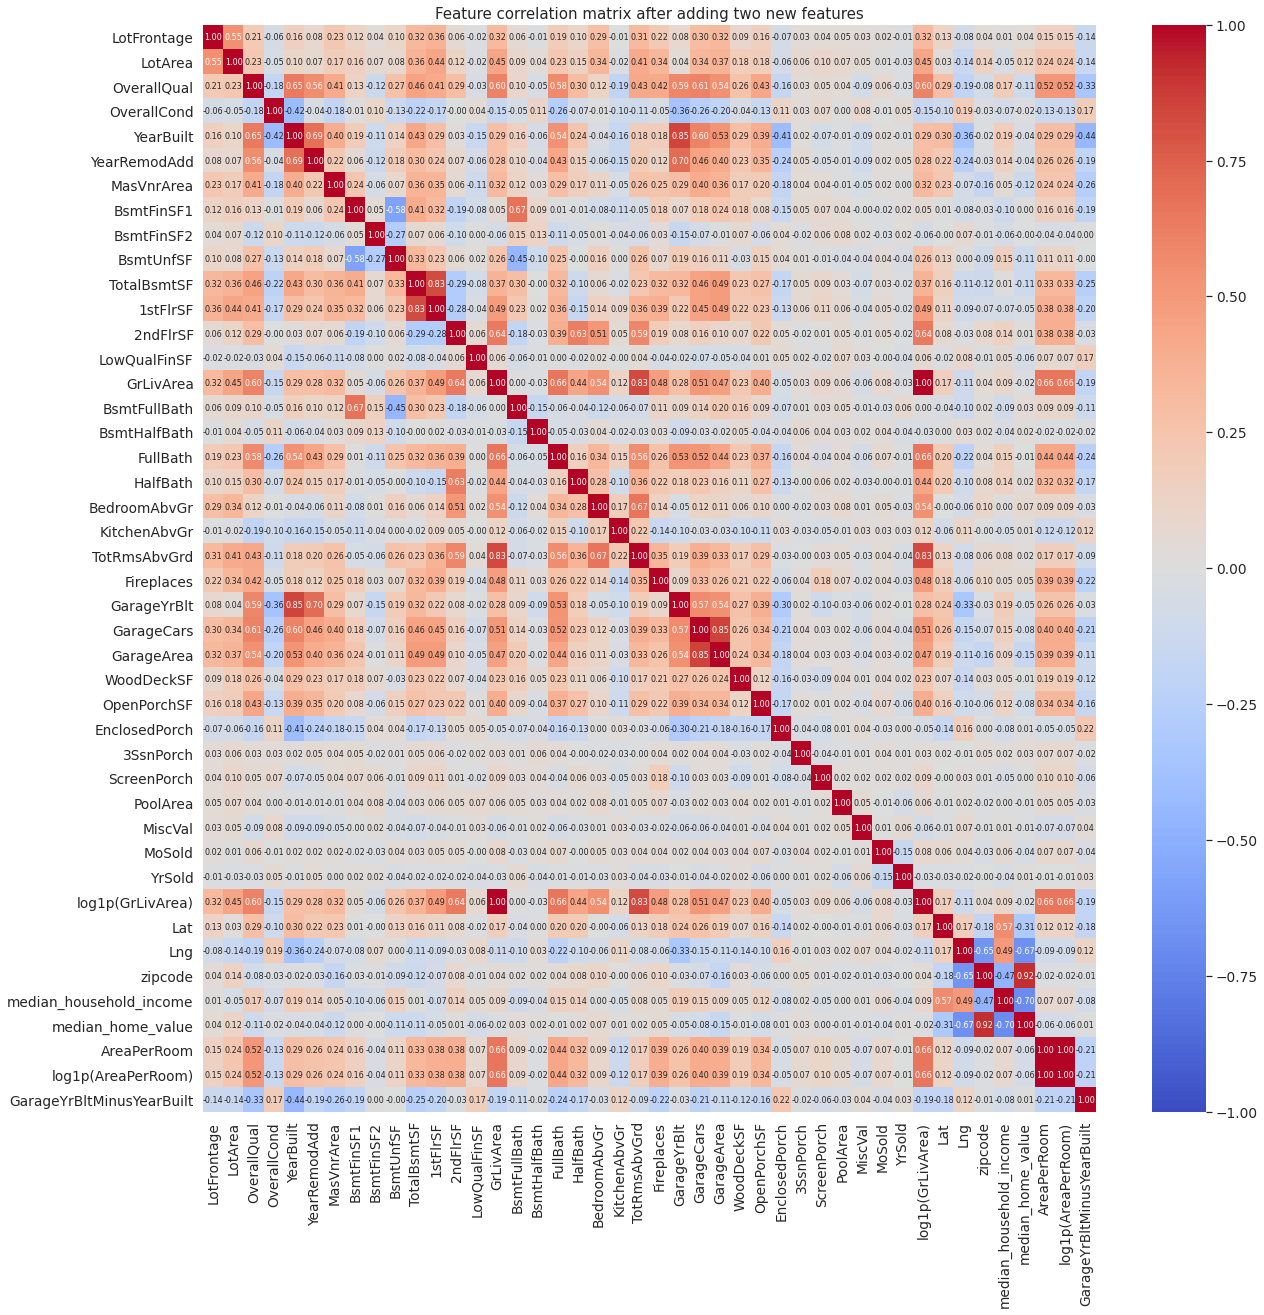

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(housing_num.corr(method='spearman'),
            vmax=1,vmin=-1,annot=True,
            cmap='coolwarm',
            fmt='.2f',annot_kws={'size':8})
_=plt.title("Feature correlation matrix after adding two new features")

Unlike the parent features, the newly added features (__AreaPerRoom__ and __GarageYrBltMinusYearBuilt__) are not that highly correlated with the rest of the features. Neither are they highly correlated with the parent features. 

### Correlation with Sale Price

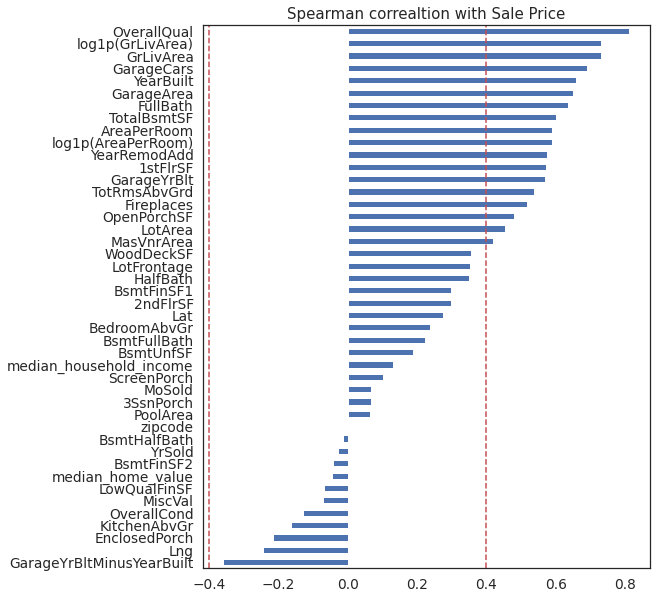

In [11]:
housing_num.corrwith(y,method='spearman').sort_values(ascending=True).plot.barh(figsize=(8,10),title = 'Spearman correaltion with Sale Price')
plt.axvline(x=0.4,linestyle='--',color='r')
plt.axvline(x=-0.4,linestyle='--',color='r')

Several features are highly correlated (> 0.4) with the sale price. One of the engineered (newly added) features, __AreaPerRoom__, is also highly correlated (~0.6) with the sale price. In fact, it is more correlated than one of its parent features from which it is derived (__TotRmsAbvGrd__). __GarageYrBlitMinusYearBuilt__ is another engineered feature. It has the highest negative correlation with the sale price. Both engineered features are candidates for predicting the sale price. 

Comments/Observation:
- Following numercial features showed strong positve correlation (>= 0.4) with the sale price (listed in descending order of their correlation strength with sale price).
    - Overall Quality (**OverallQual**)
    - Above grade living area in sq. ft. (**GrLivArea**)
    - Total garage car capacity in number of cars (**GarageCars**)
    - Year built (**YrBuilt**)
    - Garage area in sq.ft (**GarageArea**)
    - Number of full bathrooms above grade (**FullBath**)
    - Total area of the basement in sq. ft. (**TotalBsmtSF**)
    - Average size of a room in sq. ft. (**AreaPerRoom**)
    - Year when the house of remodeled (**YearRemodAdd**) 
    - Garage year built (**GarageYrBlt**)
    - Area of the first floor in sq. ft.(**1stFlrSF**)
    - Total rooms above grade (**TotRmsAbvGrd**)
    - Number of fireplaces (**FirePlaces**)
    - Open porch area in sq. ft. (**OpenPorchSF**)
    - Lot Area in sq. ft. (**LotArea**)
    - Masonry veneer area in sq, ft. (**MasVnrArea**)

## Categorical Features
### Non-parametric ANOVA

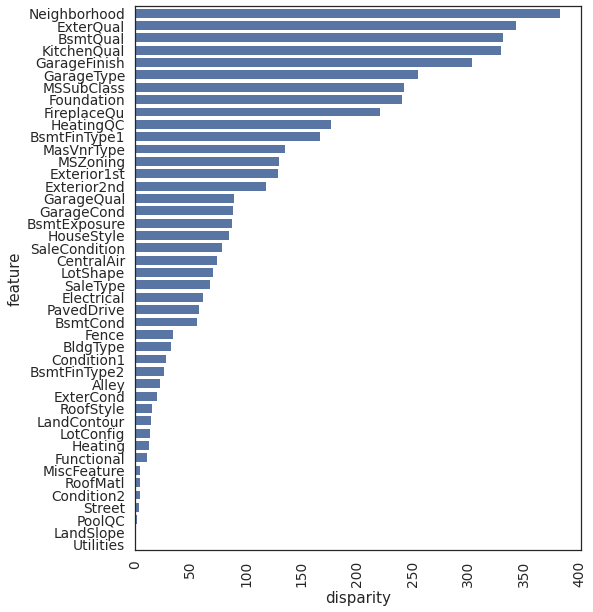

In [12]:
import scipy.stats as stats
housing_cat = housing[FEATURES['cat']]
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = frame.drop('SalePrice',axis=1).columns
    pvals = []
    for c in frame.drop('SalePrice',axis=1).columns:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.kruskal(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval').reset_index(drop=True)

a = anova(housing_cat.join(housing.SalePrice))
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(8,10))
sns.barplot(x='disparity',y='feature',data=a,color=sns.color_palette(n_colors=1)[0])
x=plt.xticks(rotation=90)

The above bar plot shows influence of each categorical feature on the sale price. Features with higher disparity have greater influence on the sale price.

### Ordinal Features

Description of following categorical feature indicate they have ordinal categories
- LandSlope
- ExterQual
- ExterCond
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- HeatingQC
- KitchenQual
- FireplaceQu
- GarageFinish
- GarageQual
- GarageCond
- PavedDrive
- PoolQC

In [13]:
ordinal_map = {'LandSlope':{'Gtl':0.,'Mod':1.,'Sev':2.},
               'ExterQual':{'Ex':4.,'Gd':3.,'TA':2.,'Fa':1.,'Po':0.},
               'ExterCond':{'Ex':4.,'Gd':3.,'TA':2.,'Fa':1.,'Po':0.},
               'BsmtQual':{'Ex':5.,'Gd':4.,'TA':3.,'Fa':2.,'Po':1.,'Missing':0.}, # Houses that don't have a basement are assigned Typical/Average rating
               'BsmtCond':{'Gd':4., 'TA':3., 'Fa':2., 'Po':1.,'Missing':0.},
               'BsmtExposure':{'Gd':4.,'Av':3.,'Mn':2.,'No':1.,'Missing':0.},
               'BsmtFinType1': {'Missing': 0.,'Unf':1.,'LwQ':2.,'Rec':3.,'BLQ':4.,'ALQ':5.,'GLQ':6.},
               'BsmtFinType2': {'Missing': 0.,'Unf':1.,'LwQ':2.,'Rec':3.,'BLQ':4.,'ALQ':5.,'GLQ':6.},
               'HeatingQC':{'Po':0.,'Fa':1.,'TA':2.,'Gd':3.,'Ex':4.},
               'KitchenQual':{'Ex':5.,'Gd':4.,'TA':3.,'Fa':2.,'Po':1.,'Missing':0},
               'FireplaceQu':{'Ex':5.,'Gd':4.,'TA':3.,'Fa':2.,'Po':1.,'Missing':0.},
               'GarageFinish':{'Fin':3., 'RFn':2., 'Unf':1., 'Missing':0.},
               'GarageQual':{'Ex':5., 'Gd':4., 'TA':3., 'Fa':2., 'Po':1., 'Missing':0.},
               'GarageCond':{'Ex':5., 'Gd':4., 'TA':3., 'Fa':2., 'Po':1., 'Missing':0.},
               'PavedDrive':{'Y':2., 'P':1., 'N':0.},
               'PoolQC':{'Ex':4., 'Gd':3., 'TA':2., 'Fa':1., 'Missing':0.}}

## Add ordinal features to FEATURES
FEATURES['ord_num'].extend(list(ordinal_map.keys()))
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num'])

In [14]:
def LabelEncode(X,mapper=ordinal_map):
    return X.replace(mapper)

LabelEncoder = FunctionTransformer(LabelEncode,validate=False,kw_args=dict(mapper=ordinal_map))
transformers.append(('LabelEncoder',LabelEncoder))

housing_cat = LabelEncoder.fit_transform(housing_cat)
housing = LabelEncoder.fit_transform(housing)

In [15]:
housing_cat[FEATURES['ord_num']].equals(housing[FEATURES['ord_num']])

True

In [16]:
housing[FEATURES['ord_num']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 1 to 1460
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LandSlope     1454 non-null   float64
 1   ExterQual     1454 non-null   float64
 2   ExterCond     1454 non-null   float64
 3   BsmtQual      1454 non-null   float64
 4   BsmtCond      1454 non-null   float64
 5   BsmtExposure  1454 non-null   float64
 6   BsmtFinType1  1454 non-null   float64
 7   BsmtFinType2  1454 non-null   float64
 8   HeatingQC     1454 non-null   float64
 9   KitchenQual   1454 non-null   float64
 10  FireplaceQu   1454 non-null   float64
 11  GarageFinish  1454 non-null   float64
 12  GarageQual    1454 non-null   float64
 13  GarageCond    1454 non-null   float64
 14  PavedDrive    1454 non-null   float64
 15  PoolQC        1454 non-null   float64
dtypes: float64(16)
memory usage: 233.1 KB


**Note: From here train and test sets are processed togather**

In [17]:
from sklearn.pipeline import Pipeline

train_raw = pd.read_csv('data/train.csv',index_col='Id')
test_raw = pd.read_csv('data/test.csv',index_col='Id')
my_pipeline = Pipeline(transformers)
my_pipeline.fit(train_raw)
train = my_pipeline.transform(train_raw)

print('Manually and pipeline created datasets are equal:')
print(housing.drop('log1p(SalePrice)',axis=1).equals(train))

test = my_pipeline.transform(test_raw)

Manually and pipeline created datasets are equal:
True


In [18]:
train_raw.shape

(1460, 80)

In [19]:
train.shape

(1454, 89)

### One hot ecoding: one hot encode following features

- MSSubClass
- MSZoning
- Street
- Alley
- LotShape
- LandContour
- Utilities
- LotConfig
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- Foundation
- Heating
- CentralAir
- Electrical
- Functional
- GarageType
- Fence
- MiscFeature
- SaleType
- SaleCondition

In [20]:
## Add onehot_cat features to FEATURES
FEATURES['onehot_cat'].extend([cat for cat in FEATURES['cat'] if cat not in FEATURES['ord_num']])
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat'])

In [21]:
train_test_cat = pd.concat([train[FEATURES['onehot_cat']],test[FEATURES['onehot_cat']]])
train_test_cat = pd.get_dummies(train_test_cat,drop_first=True)

In [22]:
train = pd.concat([train,train_test_cat.loc[train.index,:]],axis=1)
train.drop(FEATURES['onehot_cat'],axis=1,inplace=True)

test = pd.concat([test,train_test_cat.loc[test.index,:]],axis=1)
test.drop(FEATURES['onehot_cat'],axis=1,inplace=True)

y = np.log1p(train['SalePrice'])
train.drop('SalePrice',axis=1,inplace=True)

In [23]:
print('Training set size:',train.shape)

Training set size: (1454, 240)


In [24]:
print('Test set size:',test.shape)

Test set size: (1459, 240)


## Interactions
- Check pairwise feature correlations
- Create interactions of feature pairs with high correlations (> 0.4)

In [25]:
#corr_df = train.drop(['ExterQual','KitchenQual'],axis=1).corr()
corr_df = train.corr()
''' Create a dictionary with feature pairs as keys and their correlations as values'''
corr_dict = {}
for key, val in corr_df.unstack().to_dict().items():
    if (key == key[::-1]) or (key in corr_dict) or (key[::-1] in corr_dict):
        pass
    else:
        corr_dict[key] = val

In [26]:
'''Find feature pairs with corr > 0.4'''
high_corr_dict = {}
targetCorr = 0.4
for key, val in corr_dict.items():
    if val > targetCorr:
        high_corr_dict[key] = val
        
print('Total pairs with corr greater than %.2f: %i' %(targetCorr,len(high_corr_dict)))

'''Sort corr dict in descending order'''
from collections import OrderedDict
high_corr_dict = OrderedDict(sorted(high_corr_dict.items(), key=lambda x: x[1],reverse=True))
#print(high_corr_dict)

Total pairs with corr greater than 0.40: 226


In [27]:
num_feats = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num']
for feat1, feat2 in high_corr_dict:
    if (feat1 in num_feats) or (feat2 in num_feats):
        FEATURES['interactions_num'].append('X'.join([feat1,feat2]))
    else:
        FEATURES['interactions'].append('X'.join([feat1,feat2]))
    train['X'.join([feat1,feat2])] = train[feat1] * train[feat2]
    test['X'.join([feat1,feat2])] = test[feat1] * test[feat2]

In [28]:
print("Total number of training examples : " + str(train.shape[0]))
print("Total number of training features : " + str(train.shape[1]))
print("-"*50)
print("Total number of test examples : " + str(test.shape[0]))
print("Total number of test features : " + str(test.shape[1]))

Total number of training examples : 1454
Total number of training features : 466
--------------------------------------------------
Total number of test examples : 1459
Total number of test features : 466


In [29]:
with open('data/processed_data.pkl','wb') as file:
    pickle.dump((train,y,test,FEATURES),file)